In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
import copy
sys.path.append('./../../designer/script/')
sys.path.append('./../')
sys.path.append('./../../')
from film import TwoMaterialFilm, FreeFormFilm, EqOTFilm
from spectrum import Spectrum
from design import BaseDesign, DesignForSpecSimple
from optimizer.adam import AdamFreeFormOptimizer


import os
import torch

from analyze_utils.structure import plot_layer_thickness
import dill
import tqdm

def make_reflection_spec(init_film: FreeFormFilm):
    inc_ang = 0.
    # wls = np.linspace(700, 800, 500) # when wls = 50, ~100 min
    wls = np.linspace(695, 939, 500) # DBR
    R = np.ones(wls.shape[0] , dtype='float')
    target_spec = [Spectrum(inc_ang, wls, R)]
    
    return target_spec

def make_thin_reflection_spec(init_film: FreeFormFilm):
    inc_ang = 0.
    # wls = np.linspace(700, 800, 500) # when wls = 50, ~100 min
    wls = np.linspace(400, 1000, 500) # DBR
    R = np.zeros(wls.shape[0] , dtype='float')
    R[100: 150] = 1
    target_spec = [Spectrum(inc_ang, wls, R)]
    
    return target_spec


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def plot_free_form_film(ax, film, name):
    ax.plot(np.cumsum(film.get_d()), film.get_n())
    ax.set_ylim(0, 3)
    ax.set_title(name)


each_ot = 10 # nm
n_size = 200
init_n = np.sin(5 * np.linspace(0, 20, n_size)) ** 2 + 1.5

film = EqOTFilm(init_n, each_ot * n_size, substrate=1)
init_film = copy.deepcopy(film)

steps = [1, 2, 5, 10, 20, 50, 100]

fig, ax = plt.subplots(len(steps) + 1, 1, sharex=True, gridspec_kw={'hspace': .6})
fig.text(0, 0.5, 'n', va='center', rotation='vertical')

plot_free_form_film(ax[0], film, f'Inital n profile')

for i, step in enumerate(steps):
    optimizer = AdamFreeFormOptimizer(film, make_thin_reflection_spec(None), step, n_max=2.5, n_min=1.5)
    optimizer.optimize()
    plot_free_form_film(ax[i + 1], film, f'n profile after {np.sum(steps[:i+1])} optimization steps')



ax[-1].set_xlabel('Position / nm')
# fig.tight_layout()
fig.set_size_inches(6, 2 * len(steps))
fig.savefig(f'./images/freeform_demo/final.pdf', bbox_inches='tight')



/root/miniconda3/envs/tfnn/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/root/miniconda3/envs/tfnn/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
100%|██████████| 200/200 [00:08<00:00, 22.52it/s]


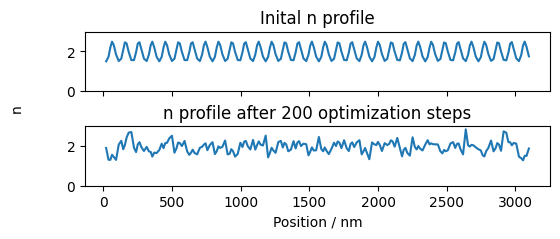

In [12]:
def plot_free_form_film(ax, film, name):
    ax.plot(np.cumsum(film.get_d()), film.get_n())
    ax.set_ylim(0, 3)
    ax.set_title(name)


each_ot = 30 # nm
n_size = 200
init_n = np.sin(5 * np.linspace(0, 20, n_size)) ** 2 + 1.5

film = EqOTFilm(init_n, each_ot * n_size, substrate=1)
init_film = copy.deepcopy(film)

# steps = [1, 2, 5, 10, 20, 50, 100]
steps = [200]
fig, ax = plt.subplots(len(steps) + 1, 1, sharex=True, gridspec_kw={'hspace': .6})
fig.text(0, 0.5, 'n', va='center', rotation='vertical')

plot_free_form_film(ax[0], film, f'Inital n profile')

for i, step in enumerate(steps):
    optimizer = AdamFreeFormOptimizer(film, make_thin_reflection_spec(None), step, n_max=3, n_min=1.2)
    optimizer.optimize()
    plot_free_form_film(ax[i + 1], film, f'n profile after {np.sum(steps[:i+1])} optimization steps')



ax[-1].set_xlabel('Position / nm')
# fig.tight_layout()
fig.set_size_inches(6, 2 * len(steps))
fig.savefig(f'./images/freeform_demo/final_thin_reflect.pdf', bbox_inches='tight')



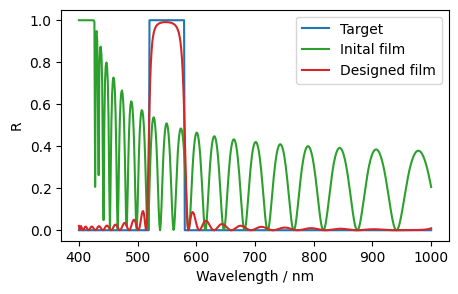

In [17]:
fig, ax = plt.subplots(1, 1)
wls = np.linspace(400, 1000, 500)
ax.plot(wls, make_thin_reflection_spec(None)[0].get_R(), label='Target', c='C0')
ax.plot(wls, init_film.get_spec(0., wls).get_R(), label='Inital film', c='C2')
ax.plot(wls, film.get_spec().get_R(), label='Designed film', c='C3')

ax.legend()
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('R')
fig.set_size_inches(5, 3)
fig.savefig('./images/freeform_demo/spec_thin_reflector.pdf', bbox_inches='tight')